In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import pandas as pd
import numpy as np
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

# Utility function to print the confusion matrix
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Data

In [0]:
# Data directory
DATADIR = 'gdrive/My Drive/HAR/UCI_HAR_Dataset'

In [0]:
# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [0]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'gdrive/My Drive/HAR/UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).as_matrix()
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [0]:
def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'gdrive/My Drive/HAR/UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0] 

    return pd.get_dummies(y).as_matrix()

In [0]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [0]:
# Importing tensorflow
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(42)

In [0]:
# Configuring a session
session_conf = tf.ConfigProto(
   intra_op_parallelism_threads=1,inter_op_parallelism_threads=1)

In [11]:
#Import Keras
from keras import backend as K
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

Using TensorFlow backend.


In [0]:
# Importing libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout
from keras.layers.normalization import BatchNormalization

In [0]:
# Initializing parameters
base_epochs = 30
base_batch_size = 32
base_n_hidden = 64

In [0]:
# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [15]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()


In [16]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))

128
9
7352


<h3>LSTM_ Base_ Model</h3>

In [0]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(base_n_hidden, input_shape=(timesteps, input_dim)))
#adding a batch normalization layer 
model.add(BatchNormalization())
# Adding a dropout layer
model.add(Dropout(0.4))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='softmax'))
model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                18944     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 390       
Total params: 19,590
Trainable params: 19,462
Non-trainable params: 128
_________________________________________________________________


In [0]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='RMSprop',
              metrics=['accuracy'])

In [0]:
%%time
# Training the model
model.fit(X_train,
          Y_train,
          batch_size=32,
          validation_data=(X_test, Y_test),
          epochs=10)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 7352 samples, validate on 2947 samples
Epoch 1/10
7352/7352 [==============================] - 66s 9ms/step - loss: 1.0304 - acc: 0.5858 - val_loss: 0.7335 - val_acc: 0.7021
Epoch 2/10
7352/7352 [==============================] - 63s 9ms/step - loss: 0.5408 - acc: 0.7896 - val_loss: 0.6607 - val_acc: 0.8008
Epoch 3/10
7352/7352 [==============================] - 61s 8ms/step - loss: 0.3138 - acc: 0.8855 - val_loss: 0.9312 - val_acc: 0.7754
Epoch 4/10
7352/7352 [==============================] - 59s 8ms/step - loss: 0.2291 - acc: 0.9128 - val_loss: 0.4118 - val_acc: 0.8850
Epoch 5/10
7352/7352 [==============================] - 58s 8ms/step - loss: 0.1920 - acc: 0.9297 - val_loss: 0.3271 - val_acc: 0.8924
Epoch 6/10
7352/7352 [==============================] - 59s 8ms/step - loss: 0.1818 - acc: 0.9346 - val_loss: 0.3125 - val_acc: 0.8938
Epoch 7/10
7352/7352 [==========================

In [0]:
score = model.evaluate(X_test, Y_test,verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1]*100)

Test loss: 0.2675111037987024
Test accuracy: 91.04173736002714


In [0]:
#train_data
X_train=X_train[:6000]
Y_train=Y_train[:6000]
#cv_data
X_cv=X_train[:1352]
Y_cv=Y_train[:1352]

In [0]:
print(X_train.shape,Y_train.shape)
print(X_cv.shape,Y_cv.shape)
print(X_test.shape,Y_test.shape)

(6000, 128, 9) (6000, 6)
(1352, 128, 9) (1352, 6)
(2947, 128, 9) (2947, 6)


In [0]:
np.save("gdrive/My Drive/HAR/x_train",X_train)
np.save("gdrive/My Drive/HAR/y_train",Y_train)
np.save("gdrive/My Drive/HAR/x_cv",X_cv)
np.save("gdrive/My Drive/HAR/y_cv",Y_cv)
np.save("gdrive/My Drive/HAR/x_test",X_test)
np.save("gdrive/My Drive/HAR/y_test",Y_test)

In [0]:
X_train=np.load('gdrive/My Drive/HAR/x_train.npy')
Y_train=np.load('gdrive/My Drive/HAR/y_train.npy')
X_cv=np.load('gdrive/My Drive/HAR/x_cv.npy')
Y_cv=np.load('gdrive/My Drive/HAR/y_cv.npy')
X_test=np.load('gdrive/My Drive/HAR/x_test.npy')
Y_test=np.load('gdrive/My Drive/HAR/y_test.npy')

In [0]:
lstms = [12,36,64]
train_lstms_loss = []
cv_lstms_loss = []



for i in lstms:
  model = Sequential()
  model.add(LSTM(i, input_shape=(timesteps, input_dim)))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Dense(n_classes, activation='softmax'))
  model.compile(loss='categorical_crossentropy',optimizer='RMSprop',metrics=['accuracy'])
  model.fit(X_train,Y_train,batch_size=32,validation_data=(X_cv, Y_cv),epochs=10,verbose=0)
  train_score = model.evaluate(X_train, Y_train,verbose=0)
  train_lstms_loss.append(train_score)
  test_score = model.evaluate(X_cv, Y_cv,verbose=0)
  cv_lstms_loss.append(test_score)
  print("==============================================================================================================================================================")
  print("for lstm cells",i,"train_loss:",train_score[0],"train_acc:",train_score[1],"cv_loss:",test_score[0],"cv_acc:",test_score[1])
  print("==============================================================================================================================================================")

for lstm cells 12 train_loss: 0.5427719736178793 train_acc: 0.7983333333333333 cv_loss: 0.5774555450977659 cv_acc: 0.7943786982248521
for lstm cells 36 train_loss: 0.1419026134143011 train_acc: 0.948 cv_loss: 0.1471664534554336 cv_acc: 0.9312130177514792
for lstm cells 64 train_loss: 0.15687254037896248 train_acc: 0.9456666666666667 cv_loss: 0.1529195671973436 cv_acc: 0.9304733727810651


In [0]:
train_dropout_loss = []
cv_dropout_loss = []
dropouts = [0.2,0.4,0.6,0.9]

for i in dropouts:
  model = Sequential()
  model.add(LSTM(64, input_shape=(timesteps, input_dim)))
  model.add(BatchNormalization())
  model.add(Dropout(i))
  model.add(Dense(n_classes, activation='softmax'))
  model.compile(loss='categorical_crossentropy',optimizer='RMSprop',metrics=['accuracy'])
  model.fit(X_train,Y_train,batch_size=32,validation_data=(X_cv, Y_cv),epochs=10,verbose=0)
  train_score = model.evaluate(X_train, Y_train,verbose=0)
  train_dropout_loss.append(train_score[0])
  test_score = model.evaluate(X_cv, Y_cv,verbose=0)
  cv_dropout_loss.append(test_score[0])
  print("========================================================================================================================================")
  print("for dropout",i,"train_loss:",train_score[0],"train_acc:",train_score[1],"cv_loss:",test_score[0],"cv_acc:",test_score[1])
  print("========================================================================================================================================")

for dropout 0.2 train_loss: 0.09121699480417676 train_acc: 0.9618333333333333 cv_loss: 0.08054623748949032 cv_acc: 0.9556213017751479
for dropout 0.4 train_loss: 0.2927109430801174 train_acc: 0.9185 cv_loss: 0.22138404586332894 cv_acc: 0.9408284023668639
for dropout 0.6 train_loss: 0.2663697602033571 train_acc: 0.9165 cv_loss: 0.2898362064807076 cv_acc: 0.915680473372781
for dropout 0.9 train_loss: 0.4850111870571758 train_acc: 0.8276666666666667 cv_loss: 0.42911438657158224 cv_acc: 0.8461538461538461


In [0]:
train_opt_loss = []
cv_opt_loss = []
optimizers = ['RMSprop','Adadelta','Adam']

for i in optimizers:
  model = Sequential()
  model.add(LSTM(64, input_shape=(timesteps, input_dim)))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))
  model.add(Dense(n_classes, activation='softmax'))
  model.compile(loss='categorical_crossentropy',optimizer=i,metrics=['accuracy'])
  model.fit(X_train,Y_train,batch_size=32,validation_data=(X_cv, Y_cv),epochs=10,verbose=0)
  train_score = model.evaluate(X_train, Y_train,verbose=0)
  train_opt_loss.append(train_score[0])
  test_score = model.evaluate(X_cv, Y_cv,verbose=0)
  cv_opt_loss.append(test_score[0])
  print("========================================================================================================================================")
  print("for optimizer ",i,"train_loss:",train_score[0],"train_acc:",train_score[1],"cv_loss:",test_score[0],"cv_acc:",test_score[1])
  print("========================================================================================================================================")

for optimizer  RMSprop train_loss: 0.09372042466270614 train_acc: 0.9646666666666667 cv_loss: 0.08798773764093963 cv_acc: 0.9563609467455622
for optimizer  Adadelta train_loss: 0.10666192313204859 train_acc: 0.9461666666666667 cv_loss: 0.0923617873280571 cv_acc: 0.9571005917159763
for optimizer  Adam train_loss: 0.09250945657089081 train_acc: 0.9641666666666666 cv_loss: 0.08666882475565281 cv_acc: 0.9548816568047337


In [0]:
model = Sequential()
model.add(LSTM(64, input_shape=(timesteps, input_dim)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(n_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='RMSprop',metrics=['accuracy'])
model.fit(X_train,Y_train,batch_size=32,validation_data=(X_test, Y_test),epochs=20,verbose=1)
score = model.evaluate(X_test, Y_test,verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1]*100)

Train on 6000 samples, validate on 2947 samples
Epoch 1/20
6000/6000 [==============================] - 57s 10ms/step - loss: 0.7780 - acc: 0.6847 - val_loss: 0.9274 - val_acc: 0.7065
Epoch 2/20
6000/6000 [==============================] - 48s 8ms/step - loss: 0.4287 - acc: 0.8255 - val_loss: 1.0003 - val_acc: 0.6176
Epoch 3/20
6000/6000 [==============================] - 49s 8ms/step - loss: 0.2508 - acc: 0.9037 - val_loss: 0.4645 - val_acc: 0.8490
Epoch 4/20
6000/6000 [==============================] - 49s 8ms/step - loss: 0.1943 - acc: 0.9327 - val_loss: 1.4064 - val_acc: 0.7598
Epoch 5/20
6000/6000 [==============================] - 49s 8ms/step - loss: 0.1708 - acc: 0.9363 - val_loss: 0.2106 - val_acc: 0.9179
Epoch 6/20
6000/6000 [==============================] - 49s 8ms/step - loss: 0.1470 - acc: 0.9448 - val_loss: 0.2387 - val_acc: 0.9223
Epoch 7/20
6000/6000 [==============================] - 48s 8ms/step - loss: 0.1351 - acc: 0.9467 - val_loss: 0.3111 - val_acc: 0.9026
Epoch 

In [0]:
model = Sequential()
model.add(LSTM(64, input_shape=(timesteps, input_dim),return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(n_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='RMSprop',metrics=['accuracy'])
model.fit(X_train,Y_train,batch_size=32,validation_data=(X_test, Y_test),epochs=20,verbose=1)
score = model.evaluate(X_test, Y_test,verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1]*100)

Train on 6000 samples, validate on 2947 samples
Epoch 1/20
6000/6000 [==============================] - 107s 18ms/step - loss: 0.4946 - acc: 0.8167 - val_loss: 1.9998 - val_acc: 0.6179
Epoch 2/20
6000/6000 [==============================] - 98s 16ms/step - loss: 0.1874 - acc: 0.9323 - val_loss: 0.5322 - val_acc: 0.8768
Epoch 3/20
6000/6000 [==============================] - 98s 16ms/step - loss: 0.1426 - acc: 0.9450 - val_loss: 0.4220 - val_acc: 0.8938
Epoch 4/20
6000/6000 [==============================] - 97s 16ms/step - loss: 0.1465 - acc: 0.9477 - val_loss: 0.2921 - val_acc: 0.9189
Epoch 5/20
6000/6000 [==============================] - 97s 16ms/step - loss: 0.1209 - acc: 0.9503 - val_loss: 0.3555 - val_acc: 0.9006
Epoch 6/20
6000/6000 [==============================] - 98s 16ms/step - loss: 0.1279 - acc: 0.9492 - val_loss: 0.4008 - val_acc: 0.9006
Epoch 7/20
6000/6000 [==============================] - 98s 16ms/step - loss: 0.1165 - acc: 0.9545 - val_loss: 0.4223 - val_acc: 0.9135

1.By using LSTM 2 layer architecture we got 93% model accuracy so by refering this paper we use a divide and conquer apporach to get some more accuracy than LSTM models Refer: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5949027/

2.So we splitting the data into 2 models one model contains 3 class labels and another contains another 3 class labels like 'STANDING,SITTING,LYING' consider as one model called static model and 'WALKING UPSTSAIRS,WALKING DOWNSTAIRS,WALKING' as another model called dynamic model 

3.First we create a binary  model i.e.., we set >3 class labels  as 1 and < 3 class labels as 0 

4.second we create a model for > 3 class labels and predict  also called as static model 

5.Third we create a model for < 3 class labels and predict also called as dynamic model 

Refer the above paper for to get some more better understading the way of implementation 


<h3> Binary model</h3>

In [17]:
#https://github.com/UdiBhaskar/Human-Activity-Recognition--Using-Deep-NN/blob/master/Human%20Activity%20Detection-Without%20Verbose%20.ipynb
# Data directory
DATADIR = 'gdrive/My Drive/HAR/UCI_HAR_Dataset'

# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'gdrive/My Drive/HAR/UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).as_matrix()
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'gdrive/My Drive/HAR/UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]
    y[y<=3] = 0 #here we scaling y_class labels 1,2,3 as 0 
    y[y>3] = 1 #here we scaling y_class labels 4,5,6 as 1

    return pd.get_dummies(y).as_matrix()

def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test
  
# Loading the train and test data
X_train_bin, X_test_bin, Y_train_bin, Y_test_bin = load_data()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [0]:
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D 
from keras.layers import Dense
from keras.layers import Flatten

In [23]:
binary_model = Sequential()
binary_model.add(Conv1D(filters=64, kernel_size=3, activation='relu',kernel_initializer='he_uniform',input_shape=(timesteps, input_dim)))
binary_model.add(BatchNormalization()) 
binary_model.add(Dropout(0.5))
binary_model.add(Conv1D(filters=32, kernel_size=3, activation='relu',kernel_initializer='he_uniform'))
binary_model.add(BatchNormalization())
binary_model.add(Dropout(0.5))
binary_model.add(MaxPooling1D(pool_size=2))
binary_model.add(Flatten())
binary_model.add(Dense(2, activation='softmax'))
binary_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 126, 64)           1792      
_________________________________________________________________
batch_normalization_3 (Batch (None, 126, 64)           256       
_________________________________________________________________
dropout_3 (Dropout)          (None, 126, 64)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 124, 32)           6176      
_________________________________________________________________
batch_normalization_4 (Batch (None, 124, 32)           128       
_________________________________________________________________
dropout_4 (Dropout)          (None, 124, 32)           0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 62, 32)           

In [25]:
binary_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy']) 
binary_model.fit(X_train_bin,Y_train_bin, epochs=30, batch_size=32,validation_data=(X_test_bin, Y_test_bin), verbose=1) 

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 6s 881us/step - loss: 0.0578 - acc: 0.9808 - val_loss: 0.0087 - val_acc: 0.9986
Epoch 2/30
7352/7352 [==============================] - 3s 357us/step - loss: 0.0079 - acc: 0.9974 - val_loss: 0.0073 - val_acc: 0.9983
Epoch 3/30
7352/7352 [==============================] - 3s 354us/step - loss: 0.0058 - acc: 0.9984 - val_loss: 0.0106 - val_acc: 0.9956
Epoch 4/30
7352/7352 [==============================] - 3s 364us/step - loss: 0.0036 - acc: 0.9990 - val_loss: 0.0030 - val_acc: 0.9990
Epoch 5/30
7352/7352 [==============================] - 3s 348us/step - loss: 0.0043 - acc: 0.9986 - val_loss: 0.0028 - val_acc: 0.9993
Epoch 6/30
7352/7352 [==============================] - 3s 359us/step - loss: 0.0010 - acc: 0.9996 - val_loss: 0.0041 - val_acc: 0.9993
Epoch 7/30
7352/7352 [==============================] - 3s 346us/step - loss: 9.2203e-04 - acc: 0.9997 - val_loss: 0.0017 - val_acc: 0.9

In [26]:
binary_model_score = binary_model.evaluate(X_test_bin,Y_test_bin,verbose=0)
print('Test loss:', binary_model_score[0])
print('Test accuracy:', binary_model_score[1]*100)

Test loss: 0.001487480033914023
Test accuracy: 99.9660671869698


In [0]:
binary_model.save('gdrive/My Drive/HAR/final_binary_model.m1')

<h3> sharpening test data </h3>

In [0]:
'''from scipy import ndimage
def sharpen(x_test, sigma, alpha):
    r = x_test.shape[0]
    c = x_test.shape[1]
    d = x_test.shape[2]
    container = np.empty((r, c, d))
    i = 0

    for row in x_test:
        test = np.array([row])
        blurred = ndimage.gaussian_filter(test, sigma)
        sharpened = test + alpha * (test - blurred)
        container[i] = sharpened
        i = i + 1
    return container'''

'from scipy import ndimage\ndef sharpen(x_test, sigma, alpha):\n    r = x_test.shape[0]\n    c = x_test.shape[1]\n    d = x_test.shape[2]\n    container = np.empty((r, c, d))\n    i = 0\n\n    for row in x_test:\n        test = np.array([row])\n        blurred = ndimage.gaussian_filter(test, sigma)\n        sharpened = test + alpha * (test - blurred)\n        container[i] = sharpened\n        i = i + 1\n    return container'

<h3>Static_Model</h3>

In [87]:
# Data directory
DATADIR = 'gdrive/My Drive/HAR/UCI_HAR_Dataset'

# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'gdrive/My Drive/HAR/UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).as_matrix()
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'gdrive/My Drive/HAR/UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]
    y_subset = y > 3 #taking y_class labels greater than 3 
    y = y[y_subset]
    return pd.get_dummies(y).as_matrix(),y_subset

def load_static_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_train_sub  = load_y('train') 
    y_test,y_test_sub = load_y('test')
    X_train = X_train[y_train_sub]
    X_test = X_test[y_test_sub]

    return X_train, X_test, y_train, y_test
  
# Loading the train and test data
X_train_static, X_test_static, Y_train_static, Y_test_static = load_static_data()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [88]:
print('X:shape',X_train_static.shape,'Y:shape',Y_train_static.shape)
#print('X:shape',X_cv_static.shape,'Y:shape',Y_cv_static.shape)
print('X:shape',X_test_static.shape,'Y:shape',Y_test_static.shape) 

X:shape (4067, 128, 9) Y:shape (4067, 3)
X:shape (1560, 128, 9) Y:shape (1560, 3)


In [0]:
import numpy
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
import keras
import keras.utils
from keras import utils as np_utils
from keras.wrappers.scikit_learn import KerasClassifier

In [0]:
%%time
def create_model(filters=1,filters2=1,kernel_size2=1,kernel_size=1,dropout_rate2=0.0,dropout_rate=0.0):
  model = Sequential()
  model.add(keras.layers.Conv1D(filters=filters, kernel_size=kernel_size,kernel_regularizer=keras.regularizers.l2(0.55), 
                                activation='relu',kernel_initializer='he_uniform',input_shape=(timesteps, input_dim)))
  model.add(BatchNormalization())
  model.add(Dropout(dropout_rate))
  model.add(keras.layers.Conv1D(filters=filters2, kernel_size=kernel_size2,kernel_regularizer=keras.regularizers.l2(0.28),
                                activation='relu',kernel_initializer='he_uniform'))
  model.add(BatchNormalization())
  model.add(Dropout(dropout_rate2))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Flatten())
  model.add(Dense(3, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy']) 
  return model
seed = 7
numpy.random.seed(seed)

model = KerasClassifier(build_fn=create_model, epochs=30, batch_size=16, verbose=0)
# define the grid search parameters 
filters = [1,32,64]
filters2 = [1,26,36]
kernel_size = [1,3,5,7]
kernel_size2 = [1,2,6,8]
dropout_rate = [0.0,0.2,0.4,0.6,0.8]
dropout_rate2 = [0.0,0.1,0.3,0.5,0.9]
param = dict(filters=filters,kernel_size=kernel_size,dropout_rate=dropout_rate,filters2=filters2,
             dropout_rate2=dropout_rate2,kernel_size2=kernel_size2)
rand = RandomizedSearchCV(estimator=model,param_distributions=param,cv=3)
rand_result = rand.fit(X_train_static, Y_train_static)
# summarize results
print("Best: %f using %s" % (rand_result.best_score_, rand_result.best_params_)) 

Best: 0.889599 using {'kernel_size2': 1, 'kernel_size': 7, 'filters2': 26, 'filters': 32, 'dropout_rate2': 0.9, 'dropout_rate': 0.2}
CPU times: user 55min, sys: 2min 12s, total: 57min 12s
Wall time: 48min 57s


In [92]:
static_model = Sequential()
static_model.add(Conv1D(filters=32, kernel_size=7, activation='relu',kernel_initializer='he_uniform',input_shape=(timesteps, input_dim)))
static_model.add(BatchNormalization()) 
static_model.add(Dropout(0.0))
static_model.add(Conv1D(filters=32, kernel_size=1, activation='relu',kernel_initializer='he_uniform'))
static_model.add(BatchNormalization())
static_model.add(Dropout(0.2))
static_model.add(Conv1D(filters=32, kernel_size=7, activation='relu',kernel_initializer='he_uniform'))
static_model.add(MaxPooling1D(pool_size=2))
static_model.add(Flatten())
static_model.add(Dense(32,activation='relu'))
static_model.add(Dense(3, activation='softmax'))
static_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy']) 
static_model.fit(X_train_static,Y_train_static, epochs=59, batch_size=32,
                 validation_data=(X_test_static, Y_test_static), verbose=1) 

Train on 4067 samples, validate on 1560 samples
Epoch 1/59
4067/4067 [==============================] - 6s 1ms/step - loss: 0.2940 - acc: 0.8788 - val_loss: 0.2683 - val_acc: 0.8910
Epoch 2/59
4067/4067 [==============================] - 2s 415us/step - loss: 0.2222 - acc: 0.9112 - val_loss: 0.3736 - val_acc: 0.8756
Epoch 3/59
4067/4067 [==============================] - 2s 404us/step - loss: 0.2306 - acc: 0.9046 - val_loss: 0.3486 - val_acc: 0.8545
Epoch 4/59
4067/4067 [==============================] - 2s 404us/step - loss: 0.2051 - acc: 0.9115 - val_loss: 0.3071 - val_acc: 0.8750
Epoch 5/59
4067/4067 [==============================] - 2s 422us/step - loss: 0.2001 - acc: 0.9134 - val_loss: 0.2938 - val_acc: 0.8929
Epoch 6/59
4067/4067 [==============================] - 2s 396us/step - loss: 0.1903 - acc: 0.9211 - val_loss: 0.2835 - val_acc: 0.9038
Epoch 7/59
4067/4067 [==============================] - 2s 401us/step - loss: 0.2079 - acc: 0.9122 - val_loss: 0.3417 - val_acc: 0.8776
Ep

In [93]:
static_model_score = static_model.evaluate(X_test_static,Y_test_static,verbose=0)
print('Test loss:', static_model_score[0])
print('Test accuracy:', static_model_score[1]*100)

Test loss: 0.25014383807258894
Test accuracy: 92.6923076923077


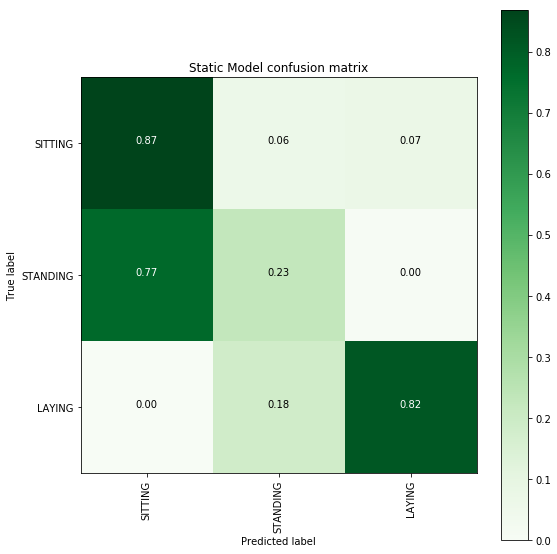

In [94]:
from sklearn.metrics import confusion_matrix
predict_static = dynamic_model.predict(X_test_static)
f_predict_static = np.argmax(predict_static,axis=1)
cm = confusion_matrix(np.argmax(Y_test_static,axis=1), f_predict_static)
plt.figure(figsize=(8,8))
labels=['SITTING','STANDING','LAYING']
plot_confusion_matrix(cm, classes=labels, 
                      normalize=True, title='Static Model confusion matrix', cmap = plt.cm.Greens)
plt.show()

Based on above confusion matrix results the class sitting and standing labels more confuse to predict  

In [0]:
static_model.save('gdrive/My Drive/HAR/final_static_model.m2')

<h3>Dynamic model</h3>

In [35]:
# Data directory
DATADIR = 'gdrive/My Drive/HAR/UCI_HAR_Dataset'

# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'gdrive/My Drive/HAR/UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).as_matrix()
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'gdrive/My Drive/HAR/UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]
    y_subset = y <= 3 #taking y_class labels less than 3 
    y = y[y_subset]
    return pd.get_dummies(y).as_matrix(),y_subset

def load_dynamic_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_train_sub  = load_y('train') 
    y_test,y_test_sub = load_y('test')
    X_train = X_train[y_train_sub]
    X_test = X_test[y_test_sub]

    return X_train, X_test, y_train, y_test
  
# Loading the train and test data
X_train_dynamic, X_test_dynamic, Y_train_dynamic, Y_test_dynamic = load_dynamic_data()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [36]:
print(X_train_dynamic.shape,Y_train_dynamic.shape)
print(X_test_dynamic.shape,Y_test_dynamic.shape)

(3285, 128, 9) (3285, 3)
(1387, 128, 9) (1387, 3)


In [0]:
import numpy
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
import keras
import keras.utils
from keras import utils as np_utils
from keras.wrappers.scikit_learn import KerasClassifier
def create_model(filters=1,filters2=1,kernel_size2=1,kernel_size=1,dropout_rate2=0.0,dropout_rate=0.0):
  model = Sequential()
  model.add(keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu',kernel_initializer='he_uniform',input_shape=(timesteps, input_dim)))
  model.add(BatchNormalization())
  model.add(Dropout(dropout_rate))
  model.add(keras.layers.Conv1D(filters=filters2, kernel_size=kernel_size2, activation='relu',kernel_initializer='he_uniform'))
  model.add(BatchNormalization())
  model.add(Dropout(dropout_rate2))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Flatten())
  model.add(Dense(3, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy']) 
  return model

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
model = KerasClassifier(build_fn=create_model, epochs=30, batch_size=16, verbose=0)
# define the grid search parameters
filters = [1,32,64]
filters2 = [1,32,64]
kernel_size = [1,3,5,7]
kernel_size2 = [1,3,5,7]
dropout_rate = [0.0,0.2,0.4,0.6,0.8]
dropout_rate2 = [0.0,0.2,0.4,0.6,0.8]
param = dict(filters=filters,kernel_size=kernel_size,dropout_rate=dropout_rate,filters2=filters2,dropout_rate2=dropout_rate2,kernel_size2=kernel_size2)
random = RandomizedSearchCV(estimator=model,param_distributions=param,cv=3)
rand_result = random.fit(X_train_dynamic, Y_train_dynamic)
# summarize results 
print("Best: %f using %s" % (rand_result.best_score_, rand_result.best_params_))

Best: 0.954642 using {'kernel_size2': 7, 'kernel_size': 1, 'filters2': 32, 'filters': 32, 'dropout_rate2': 0.2, 'dropout_rate': 0.0}


In [37]:
dynamic_model = Sequential()
dynamic_model.add(Conv1D(filters=32, kernel_size=1, activation='relu',kernel_initializer='he_uniform',input_shape=(timesteps, input_dim)))
dynamic_model.add(BatchNormalization()) 
dynamic_model.add(Dropout(0.0))
dynamic_model.add(Conv1D(filters=32, kernel_size=7, activation='relu',kernel_initializer='he_uniform'))
dynamic_model.add(BatchNormalization())
dynamic_model.add(Dropout(0.2))
dynamic_model.add(MaxPooling1D(pool_size=2))
dynamic_model.add(Flatten())
dynamic_model.add(Dense(3, activation='softmax'))
dynamic_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 128, 32)           320       
_________________________________________________________________
batch_normalization_7 (Batch (None, 128, 32)           128       
_________________________________________________________________
dropout_7 (Dropout)          (None, 128, 32)           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 122, 32)           7200      
_________________________________________________________________
batch_normalization_8 (Batch (None, 122, 32)           128       
_________________________________________________________________
dropout_8 (Dropout)          (None, 122, 32)           0         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 61, 32)           

In [38]:
dynamic_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy']) 
dynamic_model.fit(X_train_dynamic,Y_train_dynamic, epochs=30, batch_size=32,validation_data=(X_test_dynamic, Y_test_dynamic),verbose=1) 

Train on 3285 samples, validate on 1387 samples
Epoch 1/30
3285/3285 [==============================] - 2s 722us/step - loss: 0.6781 - acc: 0.7367 - val_loss: 0.4249 - val_acc: 0.8717
Epoch 2/30
3285/3285 [==============================] - 1s 342us/step - loss: 0.1024 - acc: 0.9650 - val_loss: 0.2290 - val_acc: 0.9229
Epoch 3/30
3285/3285 [==============================] - 1s 347us/step - loss: 0.0371 - acc: 0.9924 - val_loss: 0.1777 - val_acc: 0.9430
Epoch 4/30
3285/3285 [==============================] - 1s 353us/step - loss: 0.0223 - acc: 0.9948 - val_loss: 0.1433 - val_acc: 0.9560
Epoch 5/30
3285/3285 [==============================] - 1s 344us/step - loss: 0.0124 - acc: 0.9973 - val_loss: 0.1282 - val_acc: 0.9589
Epoch 6/30
3285/3285 [==============================] - 1s 347us/step - loss: 0.0138 - acc: 0.9973 - val_loss: 0.1320 - val_acc: 0.9553
Epoch 7/30
3285/3285 [==============================] - 1s 342us/step - loss: 0.0061 - acc: 0.9991 - val_loss: 0.1366 - val_acc: 0.9618


In [39]:
dynamic_model_score = dynamic_model.evaluate(X_test_dynamic,Y_test_dynamic,verbose=0)
print('Test loss:', dynamic_model_score[0])
print('Test accuracy:', dynamic_model_score[1]*100)

Test loss: 0.06151885367722327
Test accuracy: 98.19754866618601


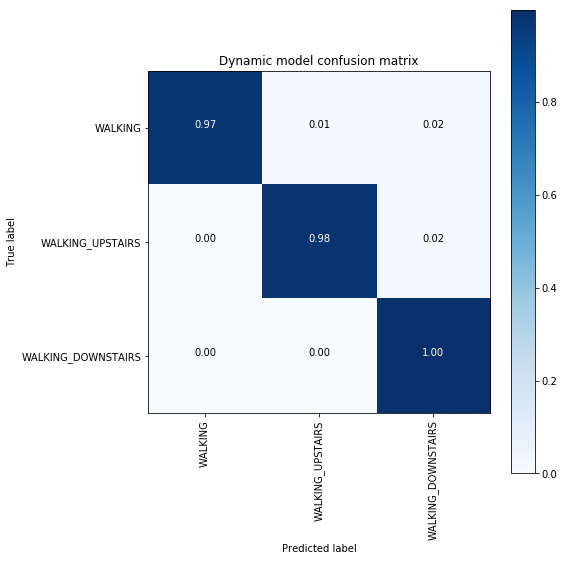

In [60]:
from sklearn.metrics import confusion_matrix
predict_dynamic = dynamic_model.predict(X_test_dynamic)
f_predict_dynamic = np.argmax(predict_dynamic,axis=1)
cm = confusion_matrix(np.argmax(Y_test_dynamic,axis=1), f_predict_dynamic)
plt.figure(figsize=(8,8))
labels=['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS']
plot_confusion_matrix(cm, classes=labels, 
                      normalize=True, title='Dynamic model confusion matrix', cmap = plt.cm.Blues)
plt.show()

In above confusion matrix results states that  98% of class labels are correctly predicted  

In [0]:
dynamic_model.save('gdrive/My Drive/HAR/final_dynamic_model.m3')

<h3>Normal model</h3>

In [41]:
# Data directory
DATADIR = 'gdrive/My Drive/HAR/UCI_HAR_Dataset'

# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'gdrive/My Drive/HAR/UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).as_matrix()
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'gdrive/My Drive/HAR/UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]
    return pd.get_dummies(y).as_matrix()

def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train,y_test = load_y('train'), load_y('test') 

    return X_train, X_test, y_train, y_test
  
# Loading the train and test data
Q_X_train, Q_X_test, Q_Y_train, Q_Y_test = load_data()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [0]:
from keras.models import load_model
b_model = load_model('gdrive/My Drive/HAR/final_binary_model.m1')
s_model = load_model('gdrive/My Drive/HAR/final_static_model.m2')
d_model = load_model('gdrive/My Drive/HAR/final_dynamic_model.m3')

In [0]:
#predicting output activity
def predict(X):
    ##predicting whether dynamic or static
    predict_binary = binary_model.predict(X)
    f_predict_binary =  np.argmax(predict_binary, axis=1)
    #static data filter
    X_static = X[f_predict_binary==1]
    #dynamic data filter
    X_dynamic = X[f_predict_binary==0]
    #predicting static activities
    predict_static = static_model.predict(X_static)
    f_predict_static = np.argmax(predict_static,axis=1)
    #adding 3 because need to get inal prediction lable as output
    f_predict_static = f_predict_static + 3 
    #predicting dynamic activites
    predict_dynamic = dynamic_model.predict(X_dynamic)
    f_predict_dynamic = np.argmax(predict_dynamic,axis=1)
    #adding 1 because need to get inal prediction lable as output
    f_predict_dynamic = f_predict_dynamic 
    ##appending final output to one list in the same sequence of input data
    i,j = 0,0 
    final_predict = []
    for q_p in f_predict_binary:
        if q_p == 1:
            final_predict.append(f_predict_static[i])
            i = i + 1
        else:
            final_predict.append(f_predict_dynamic[j])
            j = j + 1 
    return final_predict

In [44]:
from sklearn.metrics import accuracy_score
train_pred = predict(Q_X_train)
test_pred = predict(Q_X_test)
print('Accuracy of train data',accuracy_score(np.argmax(Q_Y_train,axis=1),train_pred))
print('Accuracy of validation data',accuracy_score(np.argmax(Q_Y_test,axis=1),test_pred))

Accuracy of train data 0.9802774755168662
Accuracy of validation data 0.9460468272819816


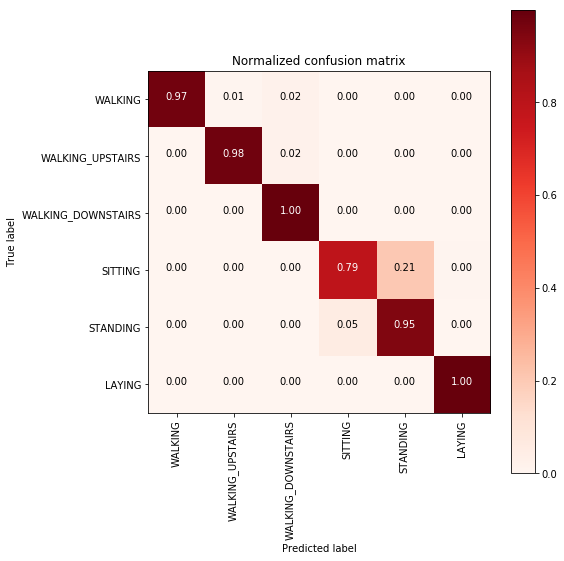

In [47]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(np.argmax(Q_Y_test,axis=1), test_pred)
plt.figure(figsize=(8,8))
labels=['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS','SITTING','STANDING','LAYING']
plot_confusion_matrix(cm, classes=labels, 
                      normalize=True, title='Normalized confusion matrix', cmap = plt.cm.Reds)
plt.show()

In [96]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Model", "Accuracy"]
x.add_row(["LSTM BASE MODEL ",  '91%'])
x.add_row(["LSTM 2 Layer ", '93%'])
x.add_row(["Static model ", '92%'])
x.add_row(["Dynamic model ", '98%'])
x.add_row(["Binary + static + dynamic ", '94%'])
print(x)

+----------------------------+----------+
|           Model            | Accuracy |
+----------------------------+----------+
|      LSTM BASE MODEL       |   91%    |
|       LSTM 2 Layer         |   93%    |
|       Static model         |   92%    |
|       Dynamic model        |   98%    |
| Binary + static + dynamic  |   94%    |
+----------------------------+----------+


<h3>Observations</h3>

<ol>
<li>In this dataset about Human activity Recoginition using smart phones data, Various LSTM and CNN deep learning techniques are applied </li>
<li>We got the results by using LSTM we got 93% accuracy  </li>
<li>By applying the new concept called Divide and conquer we dividede te data into two parts </li>
<li>Applied first 3 class labels as one model and remaining 3 class labels as another model and predicted individually </li>
<li>first 3 class label models called dynamic models and last 3 class labels called as static models </li>
<li>Applied as 2 models and we got Static model as 92% accuracy and dynamic model as 98% accuracy </li>
<li>In static model there is a lot of confusion between standing and sitting class labels because of that confusion it gives lower accuracy </li>
<li>But in dynamic models it gives excellent classification it gaves 98% accuracy </li>
<li>Overall by combing all these  6 labels we got 94% as final accuracy by using  concept called divde and conquer </li>






</ol>